# Theme of this notebook - Three subset selection methods

* This is a memo for what subset selection is, three types of subset selection methods, and how to implement them in Python.

## 1.What is subset selection?

* Subset selection is a statistical method used in regression analysis to select a subset of predictors that provides the best predictive model.
* The purpuse is to improve model accuracy, reduce complexity, and avoid overfitting by eliminating redundant or irrelevant predictors.

## 2.Theee types of subset selection methods

1. <b><u>Best subset selection</b></u>: This method evaluates all possible combinations of features to find the absolute best subset. However, it can be computationally expensive for large datasets.
2. <b><u>Forward selection</b></u>: Starting with no features, you gradually add the most informative features one by one. It is a kind of greedy algorithm.
3. <b><u>Backward selection</b></u>: Starting with all features, you iteratively remove the least informative ones.

* For detail explanation, please refer to
"stat-013_Three_subset_selection_methods_explanation.pdf"

## 3.Sample codes for Python

* Let's try to predict a baseball player’s Salary on the basis of various statistics associated with performance in the previous year

In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [7]:
# Load dataset
df = pd.read_csv('stats-13_sample_dataset.csv')
df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [8]:
# Check whether there are any missing data
print(df["Salary"].isnull().sum())

59


In [9]:
# Let's drop the missing data
# Drop the player names as they are not a reasonable potential predictor
df = df.drop('Player', axis=1)
# Print the dimensions of the Hitters data (322 rows x 20 columns)(Players'␣ ↪names not included)
print("before dropna():",df.shape)
# Drop any rows the contain missing values. Note that this is not necessarily␣ ↪the recommended practice for a given problem.
df = df.dropna()
# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("after dropna():",df.shape)
# One last check: should return 0
print("check the number of missing salary after dropna():",df["Salary"].isnull().sum())

before dropna(): (322, 20)
after dropna(): (263, 20)
check the number of missing salary after dropna(): 0


In [10]:
# The following data are not numerical
df[['League', 'Division', 'NewLeague']].head()

,League,Division,NewLeague
1,N,W,N
2,A,W,A
3,N,E,N
4,N,E,N
5,A,W,A


In [11]:
# Transform categorical data into numerical data by using one-hot encoding
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,False,True,False,True,False,True
2,True,False,False,True,True,False
3,False,True,True,False,False,True
4,False,True,True,False,False,True
5,True,False,False,True,True,False


In [12]:
# Set a response variable (This case: salary)
y = df.Salary
dummies=dummies.astype(int) #this datatype conversion is needed later on when fitting OLS

# Drop the column with the dependent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1)
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [13]:
# Before performing the best subset selection, we should define what "best" is in terms of what.
# In this case, let's define that "best" is quantified in terms of having the smallest RSS.
# So, define a function calculatting RSS

def processSubset(feature_set):
  # Fit model on feature_set and calculate RSS
  X1 = sm.add_constant(X[list(feature_set)])
  model = sm.OLS(y,X1)
  regr = model.fit()
  RSS = ((regr.predict(X1) - y) ** 2).sum()
  return {"model":regr, "RSS":RSS}

### 3.1.Best Subset Selection

In [15]:
# Define the function of best subset selection
def Best_subset_selection(k):
  tic = time.time()
  results = []
  for combo in itertools.combinations(X.columns, k):
    results.append(processSubset(combo))

  # Wrap everything up in a nice dataframe
  models = pd.DataFrame(results)

  # Choose the model with the smallest RSS
  best_model = models.loc[models['RSS'].idxmin()]
  # idxmin() function returns index of first occurrence of minimum.

  toc = time.time()

  print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")

  # Return the best model, along with some other useful information about the␣ ↪model
  return best_model

In [16]:
# Let's perform best subset selection
# (But it costs us longer times...this is what "computationally expensive" means.)
models = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()

for i in range(0,8):
  models.loc[i] = Best_subset_selection(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  1 models on 0 predictors in 0.024521827697753906 seconds.
Processed  19 models on 1 predictors in 0.19878673553466797 seconds.
Processed  171 models on 2 predictors in 0.5970957279205322 seconds.
Processed  969 models on 3 predictors in 3.3416588306427 seconds.
Processed  3876 models on 4 predictors in 17.36527943611145 seconds.
Processed  11628 models on 5 predictors in 56.83463907241821 seconds.
Processed  27132 models on 6 predictors in 148.06013679504395 seconds.
Processed  50388 models on 7 predictors in 314.254709482193 seconds.
Total elapsed time: 541.6101365089417 seconds.


In [17]:
# Check the dataframe
models

,RSS,model
0,53319112.788645,<statsmodels.regression.linear_model.Regressio...
1,36179679.255042,<statsmodels.regression.linear_model.Regressio...
2,30646559.890373,<statsmodels.regression.linear_model.Regressio...
3,29249296.855867,<statsmodels.regression.linear_model.Regressio...
4,27970851.815816,<statsmodels.regression.linear_model.Regressio...
5,27149899.432012,<statsmodels.regression.linear_model.Regressio...
6,26194903.927595,<statsmodels.regression.linear_model.Regressio...
7,25906547.500624,<statsmodels.regression.linear_model.Regressio...


In [20]:
# Check how RSS changes as predictors increase
models.apply(lambda row: row[1].rsquared, axis=1)

0    1.110223e-16
1    3.214501e-01
2    4.252237e-01
3    4.514294e-01
4    4.754067e-01
5    4.908036e-01
6    5.087146e-01
7    5.141227e-01
dtype: float64

Text(0, 0.5, 'BIC')

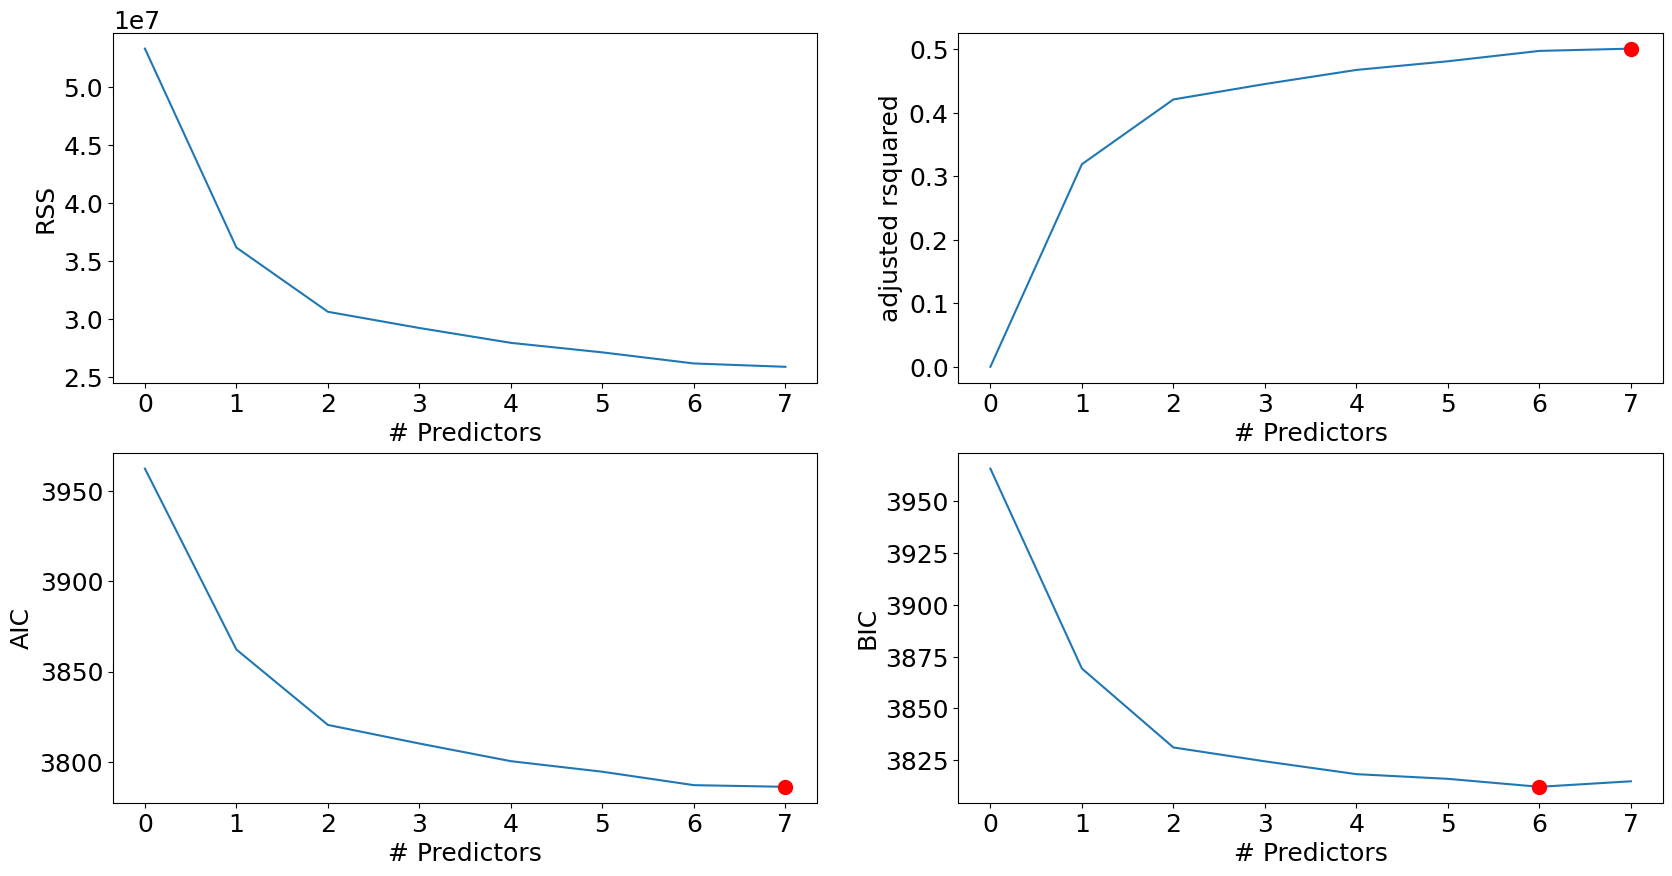

In [21]:
# Plotting 𝑅𝑆𝑆, adjusted-𝑅 , 𝐴𝐼𝐶, and 𝐵𝐼𝐶 for all of the models at once
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# Plot a curve to show the relationship between the number of predictors and the RSS
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# Plot a red dot to indicate the model with the largest adjusted R2 statistic.
# The idxmax() function can be used to identify the location of the maximum point of a vector
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# Do the same for AIC and BIC, this time looking for the models with the smallest statistic
aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')
bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

### 3.2.Forward Stepwise Selection

In [22]:
# Define the function of forward stepwise selection
def forward(predictors):
  # Pull out predictors we still need to process
  remaining_predictors = [p for p in X.columns if p not in predictors]
  tic = time.time()
  results = []
  for p in remaining_predictors:
    results.append(processSubset(predictors+[p]))

  # Wrap everything up in a nice dataframe
  models = pd.DataFrame(results)
  # Choose the model with the highest RSS
  best_model = models.loc[models['RSS'].idxmin()]
  toc = time.time()

  print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")

  # Return the best model, along with some other useful information about the␣ ↪model
  return best_model

In [23]:
# Let's perform forward stepwise selection
models2 = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):
  models2.loc[i] = forward(predictors)
  predictors = models2.loc[i]["model"].model.exog_names.copy()
  predictors.remove('const')

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.06008744239807129 seconds.
Processed  18 models on 2 predictors in 0.06170058250427246 seconds.
Processed  17 models on 3 predictors in 0.06934142112731934 seconds.
Processed  16 models on 4 predictors in 0.06928753852844238 seconds.
Processed  15 models on 5 predictors in 0.07998394966125488 seconds.
Processed  14 models on 6 predictors in 0.058846473693847656 seconds.
Processed  13 models on 7 predictors in 0.06136798858642578 seconds.
Processed  12 models on 8 predictors in 0.07212281227111816 seconds.
Processed  11 models on 9 predictors in 0.05921030044555664 seconds.
Processed  10 models on 10 predictors in 0.06879758834838867 seconds.
Processed  9 models on 11 predictors in 0.05139017105102539 seconds.
Processed  8 models on 12 predictors in 0.046288251876831055 seconds.
Processed  7 models on 13 predictors in 0.07437849044799805 seconds.
Processed  6 models on 14 predictors in 0.04394054412841797 seconds.
Processed  5 models on 15 predi

[Comment]<br>
Super Fast!!

In [24]:
# Let’s see how the forward stepwise selection models stack up against best subset selection for models with 7 predictors:
print("Best Subset Selection:\n", models.loc[7, "model"].summary())
print("\n\nForward Stepwise Selection:\n", models2.loc[7, "model"].summary())

Best Subset Selection:
                             OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     38.55
Date:                Fri, 24 May 2024   Prob (F-statistic):           1.19e-36
Time:                        01:12:07   Log-Likelihood:                -1885.1
No. Observations:                 263   AIC:                             3786.
Df Residuals:                     255   BIC:                             3815.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.4509     63

[Comment]<br>
Certainly, the adjusted R2 of best subset selection is better than that of forward stepwise selection.<br>
But the difference was only 0.001%!<br>
So, considering the computational costs of best subset selection, forward stepwise selection is generally recommended when we find predictors from large datasets

### 3.3.Backward Stepwise Selection

In [25]:
# Define the function of backward stepwise selection
def backward(predictors):
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
      results.append(processSubset(combo))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")

    # Return the best model, along with some other useful information about the␣ ↪model
    return best_model

In [27]:
# Let's perform forward stepwise selection
models3 = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

models3.loc[len(predictors)] = Best_subset_selection(len(predictors))

while(len(predictors) > 1):
  models3.loc[len(predictors)-1] = backward(predictors)
  predictors = models3.loc[len(predictors)-1]["model"].model.exog_names.copy()
  predictors.remove('const')

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  1 models on 19 predictors in 0.04061126708984375 seconds.
Processed  19 models on 18 predictors in 0.4000978469848633 seconds.
Processed  18 models on 17 predictors in 0.5267589092254639 seconds.
Processed  17 models on 16 predictors in 0.38173604011535645 seconds.
Processed  16 models on 15 predictors in 0.5444974899291992 seconds.
Processed  15 models on 14 predictors in 0.40209317207336426 seconds.
Processed  14 models on 13 predictors in 0.5564413070678711 seconds.
Processed  13 models on 12 predictors in 0.4093806743621826 seconds.
Processed  12 models on 11 predictors in 0.2753617763519287 seconds.
Processed  11 models on 10 predictors in 0.1464691162109375 seconds.
Processed  10 models on 9 predictors in 0.0999605655670166 seconds.
Processed  9 models on 8 predictors in 0.09755206108093262 seconds.
Processed  8 models on 7 predictors in 0.06473302841186523 seconds.
Processed  7 models on 6 predictors in 0.0775442123413086 seconds.
Processed  6 models on 5 predictors i

In [28]:
#For this data, the best 7-variable models identified by
# forward stepwise selection, backward stepwise selection, and best subset selection are different.
print("Best Subset Selection:\n",models.loc[7, "model"].params)
print("\nForward Stepwise Selection:\n",models2.loc[7, "model"].params)
print("\nBackward Stepwise Selection:\n",models3.loc[7, "model"].params)

Best Subset Selection:
 const          79.450947
Hits            1.283351
Walks           3.227426
CAtBat         -0.375235
CHits           1.495707
CHmRun          1.442054
PutOuts         0.236681
Division_W   -129.986643
dtype: float64

Forward Stepwise Selection:
 const         109.787306
CRBI            0.853762
Hits            7.449877
PutOuts         0.253340
Division_W   -127.122393
AtBat          -1.958885
Walks           4.913140
CWalks         -0.305307
dtype: float64

Backward Stepwise Selection:
 const         105.648749
AtBat          -1.976284
Hits            6.757491
Walks           6.055869
CRuns           1.129309
CWalks         -0.716335
PutOuts         0.302885
Division_W   -116.169217
dtype: float64
